In [1]:
import os
if type(os.environ.get('DISPLAY')) is not str or len(os.environ.get('DISPLAY'))== 0:
    !bash ../xbfb start
    %env DISPLAY = :1

env: DISPLAY=:1


'bash' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
%%writefile qlearning.py
from collections import defaultdict
import random, math
import numpy as np

class QLearningAgent :
    
    def __init__(self,alpha,epsilon,discount,get_legal_actions):
        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda :0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
    
    def get_qvalue(self,state,action):
        return self._qvalues[state][action]
    
    def set_qvalue(self,state,action,value):
        self._qvalues[state][action] = value
    
    def get_value(self,state):
        possible_actions = self.get_legal_actions(state)
        if len(possible_actions) == 0:
            return 0.0
        possible_values = [self.get_qvalue(state,action) for action in possible_actions]
        state_value = np.max(possible_values)
        return state_value
    
    def update(self,state,action,reward,next_state):
        gamma = self.discount
        learning_rate = self.alpha
        qvalue = (1-learning_rate) * self.get_qvalue(state,action) + learning_rate * (reward + gamma * self.get_value(next_state))
        self.set_qvalue(state,action,qvalue)
        
    def get_best_action(self,state):
        possible_actions = self.get_legal_actions(state)
        if len(possible_actions) == 0:
            return None
        possible_q_values = [self.get_qvalue(state,action) for action in possible_actions]
        index = np.argmax(possible_q_values)
        best_action = possible_actions[index]
        return best_action
    
    def get_action(self,state):
        possible_actions = self.get_legal_actions(state)
        action = None
        if len(possible_actions) == 0:
            return None
        epsilon = self.epsilon
        choice = np.random.random() > epsilon
        if choice:
            chosen_action = self.get_best_action(state)
        else:
            chosen_action = random.choice(possible_actions)
        return chosen_action

Overwriting qlearning.py


# Try it on Taxi 

In [6]:
import gym
env = gym.make('Taxi-v2')
n_actions = env.action_space.n

c:\users\yingg\desktop\myproject0\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [10]:
from qlearning import QLearningAgent
agent = QLearningAgent(alpha = 0.5, epsilon = 0.25, discount = 0.99,
                      get_legal_actions = lambda s: range(n_actions))

In [11]:
def play_and_train(env,agent,t_max=10**4):
    total_reward = 0.0
    s = env.reset()
    for t in range(t_max):
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)
        agent.update(s,a,r,next_s)
        s = next_s
        total_reward += r
        if done:break
    return total_reward

eps = 8.158541442036598e-36 mean reward = 8.6


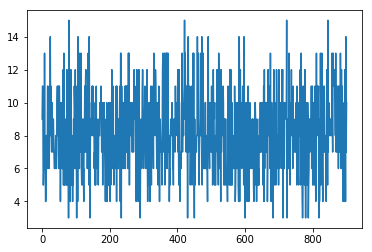

In [32]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99
    
    if i %100 ==0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

# CartPole -- Binarized state spaces

c:\users\yingg\desktop\myproject0\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


first state: [-0.02650561 -0.01770463  0.03923905  0.04844029]


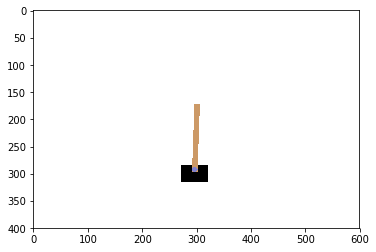

In [34]:
env = gym.make('CartPole-v0')
n_actions = env.action_space.n
print('first state: %s' % (env.reset()))
plt.imshow(env.render('rgb_array'))

## play a few games 

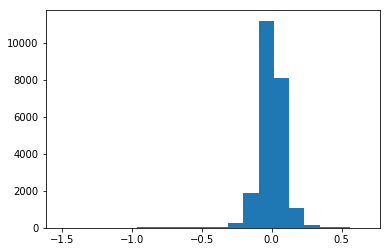

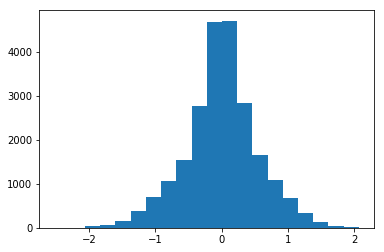

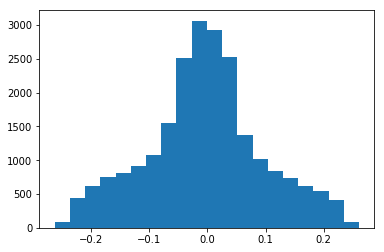

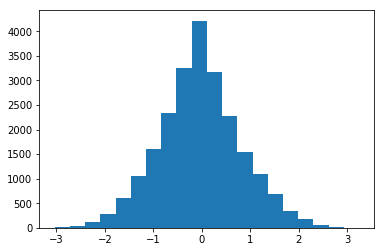

In [36]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s,r,done,_=env.step(env.action_space.sample())
        all_states.append(s)
        if done:break
all_states = np.array(all_states)
for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:,obs_i],bins=20)
    plt.show()

In [37]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):
    def _observation(self,state):
        state[0] = np.round(state[0],3)
        state[1] = np.round(state[1],1)
        state[2] = np.round(state[2],2)
        state[3] = np.round(state[3],1)
        
        return tuple(state)